# forensicface--A tool for forensic face examination

> An integrated tool to compare faces using state-of-the-art face recognition models and compute Likelihood Ratios 

In [ ]:
# | default_exp app

In [ ]:
# | export
from nbdev.showdoc import *
from fastcore.utils import *
import onnxruntime
import cv2
import numpy as np
import os.path as osp
from glob import glob
from imutils import build_montages
from insightface.app import FaceAnalysis
from insightface.utils import face_align
from tqdm import tqdm
from forensicface.utils import freeze_env, transform_keypoints, annotate_img_with_kps

In [ ]:
# | export
class ForensicFace:
    """
    Class for processing facial images to extract useful features for forensic analysis.
    """

    def __init__(
        self,
        model: str = "sepaelv2",
        det_size: int = 320,
        use_gpu: bool = True,
        gpu: int = 0,  # which GPU to use
        extended=True,
        det_thresh: float = 0.5,
    ):
        """
        A face comparison tool for forensic analysis and comparison of facial images.

        Args:
        - model (str): The name of the face recognition model to use (default: "sepaelv2").
        - det_size (int): The size of the input images for face detection (default: 320).
        - use_gpu (bool): Whether to use a GPU for inference (default: True).
        - gpu (int): The ID of the GPU to use (default: 0).
        - extended (bool): Whether to use extended modules (detection, landmark_3d_68, genderage) (default: True).
        - det_thresh (float): threshold for the face detector (default = 0.5).
        """
        self.extended = extended
        if self.extended == True:
            allowed_modules = ["detection", "landmark_3d_68", "genderage"]
            self.ort_fiqa = onnxruntime.InferenceSession(
                osp.join(
                    osp.expanduser("~/.insightface/models"),
                    model,
                    "cr_fiqa",
                    "cr_fiqa_l.onnx",
                ),
                providers=(
                    [("CUDAExecutionProvider", {"device_id": gpu})]
                    if use_gpu
                    else ["CPUExecutionProvider"]
                ),
            )
        else:
            allowed_modules = ["detection"]

        self.det_size = (det_size, det_size)
        self.det_thresh = det_thresh

        self.model = model

        self.detectmodel = FaceAnalysis(
            name=model,
            allowed_modules=allowed_modules,
            providers=(
                [("CUDAExecutionProvider", {"device_id": gpu})]
                if use_gpu
                else ["CPUExecutionProvider"]
            ),
        )
        self.detectmodel.prepare(
            ctx_id=gpu if use_gpu else -1,
            det_size=self.det_size,
            det_thresh=self.det_thresh,
        )

        onnx_rec_model = glob(
            osp.join(
                osp.expanduser("~/.insightface/models"),
                model,
                "adaface",
                "adaface_*.onnx",
            )
        )
        assert len(onnx_rec_model) == 1
        self.ort_ada = onnxruntime.InferenceSession(
            onnx_rec_model[0],
            providers=(
                [("CUDAExecutionProvider", {"device_id": gpu})]
                if use_gpu
                else ["CPUExecutionProvider"]
            ),
        )

        self.environment = freeze_env()

    def _to_input_ada(self, aligned_bgr_img):
        """
        Preprocesses the input face for the face recognition model.

        Args:
            face: Face image as a numpy array in BGR order.

        Returns:
            Preprocessed face image as a numpy array.
        """
        _aligned_bgr_img = aligned_bgr_img.astype(np.float32)
        _aligned_bgr_img = ((_aligned_bgr_img / 255.0) - 0.5) / 0.5
        return _aligned_bgr_img.transpose(2, 0, 1).reshape(1, 3, 112, 112)

    def get_most_central_face(self, img, faces):
        """
        Get the keypoints of the most central face in an image.

        Args:
            img: Input image as a numpy array.
            faces: An insightface object with keypoints and bounding_box.

        Returns:
            Tuple containing the index of the most central face and its keypoints.
        """
        assert faces is not None
        img_center = np.array([img.shape[0] // 2, img.shape[1] // 2])
        dist = []

        # Compute centers of faces and distances from certer of image
        for idx, face in enumerate(faces):
            box = face.bbox.astype("int").flatten()
            face_center = np.array([(box[0] + box[2]) // 2, (box[1] + box[3]) // 2])
            dist.append(np.linalg.norm(img_center - face_center))

        # Get index of the face closest to the center of image
        idx = dist.index(min(dist))
        return idx, faces[idx].kps

    def get_larger_face(self, img, faces):
        """
        Get the keypoints of the larger face in an image.

        Args:
            img: Input image as a numpy array.
            faces: An insightface object with keypoints and bounding_box.

        Returns:
            Tuple containing the index of the larger face and its keypoints.
        """
        assert faces is not None
        areas = []

        # Compute centers of faces and distances from certer of image
        for idx, face in enumerate(faces):
            box = face.bbox.astype("int").flatten()
            areas.append(abs((box[2] - box[0]) * (box[3] - box[1])))

        # Get index of the face closest to the center of image
        idx = areas.index(max(areas))
        return idx, faces[idx].kps

    def process_image_single_face(
        self, imgpath: str, draw_keypoints=False
    ):  # Path to image to be processed
        """
        Process a an image considering it has a single face and extract useful features for forensic analysis.

        Args:
            - imgpath (str): Path to the input image.
            - draw_keypoints (bool): If set to True, draw keypoints used to face alignment into the aligned face.

        Returns:
            A dictionary containing the following keys:
                - 'keypoints': A 2D numpy array of shape (5, 2) containing the facial keypoints
                        for each face in the image. The keypoints are ordered as follows:
                       left eye, right eye, nose tip, left mouth corner, and right mouth corner.

                - 'ipd': A float representing the inter-pupillary distance for each face in the image.

                - 'embedding': A 1D numpy array of shape (512,) containing the facial embedding
                       for each face in the image.

                - 'norm': A float representing the L2 norm of the embedding for each face in the image.

                - 'bbox': A 1D numpy array of shape (4,) containing the bounding box coordinates for each face
                  in the image. The coordinates are ordered as follows: (xmin, ymin, xmax, ymax).

                - 'aligned_face': A 3D numpy array of shape (H, W, C) in RGB order containing the aligned face image for
                          each face in the image. The image has been cropped and aligned based on the
                          facial keypoints.

                If the 'extended' attribute is set to True, the dictionary will also contain the following keys:
                - 'gender': A string representing the gender for each face in the image.
                               Possible values are 'M' for male and 'F' for female.

                - 'age': An integer representing the estimated age for each face in the image.

                - 'pitch': A float representing the pitch angle for each face in the image.

                - 'yaw': A float representing the yaw angle for each face in the image.

                - 'roll': A float representing the roll angle for each face in the image.

                - 'det_score': A float representing the face detection score.
        """
        if type(imgpath) == str:  # image path passed as argument
            bgr_img = cv2.imread(imgpath)
        else:  # image array passed as argument
            bgr_img = imgpath.copy()
        faces = self.detectmodel.get(bgr_img)
        if len(faces) == 0:
            return {}

        idx, kps = self.get_larger_face(bgr_img, faces)

        bbox = faces[idx].bbox.astype("int")
        bgr_aligned_face = face_align.norm_crop(bgr_img, kps)
        if draw_keypoints == True:
            M = face_align.estimate_norm(kps)
            aligned_kps = transform_keypoints(keypoints=kps, M=M)
            bgr_aligned_face = annotate_img_with_kps(
                bgr_aligned_face, kps=aligned_kps, color="green"
            )

        ipd = np.linalg.norm(kps[0] - kps[1])
        det_score = faces[idx].det_score

        ada_inputs = {
            self.ort_ada.get_inputs()[0].name: self._to_input_ada(bgr_aligned_face)
        }
        normalized_embedding, norm = self.ort_ada.run(None, ada_inputs)

        ret = {
            "keypoints": kps,
            "ipd": ipd,
            "embedding": normalized_embedding.flatten() * norm.flatten()[0],
            "norm": norm.flatten()[0],
            "bbox": bbox,
            "det_score": det_score,
            "aligned_face": cv2.cvtColor(bgr_aligned_face, cv2.COLOR_BGR2RGB),
        }

        if self.extended:
            gender = "M" if faces[idx].gender == 1 else "F"
            age = faces[idx].age
            pitch, yaw, roll = faces[idx].pose
            _, fiqa_score = self.ort_fiqa.run(None, ada_inputs)
            ret = {
                **ret,
                **{
                    "gender": gender,
                    "age": age,
                    "pitch": pitch,
                    "yaw": yaw,
                    "roll": roll,
                    "fiqa_score": fiqa_score[0][0],
                },
            }

        return ret

    def process_image(self, imgpath, draw_keypoints=False):
        return self.process_image_single_face(imgpath, draw_keypoints)

    def process_image_multiple_faces(
        self, imgpath: str, draw_keypoints=False  # Path to image to be processed
    ):
        """
        Process an image with one or multiple faces and returns a list of dictionaries
        with the following keys:

            - 'keypoints': A 2D numpy array of shape (5, 2) containing the facial keypoints
                            for each face in the image. The keypoints are ordered as follows:
                            left eye, right eye, nose tip, left mouth corner, and right mouth corner.

            - 'ipd': A float representing the inter-pupillary distance for each face in the image.

            - 'embedding': A 1D numpy array of shape (512,) containing the facial embedding
                            for each face in the image.

            - 'norm': A float representing the L2 norm of the embedding for each face in the image.

            - 'bbox': A 1D numpy array of shape (4,) containing the bounding box coordinates for each face
                        in the image. The coordinates are ordered as follows: (xmin, ymin, xmax, ymax).

            - 'aligned_face': A numpy array of shape (112, 112, 3) in RGB order containing the aligned face image for
                                each face in the image. The image has been cropped and aligned based on the
                                facial keypoints.

         If the 'extended' attribute is set to True, the dictionaries will also contain the following keys:
            - 'gender': A string representing the sex for each face in the image.
                        Possible values are 'M' for male and 'F' for female.

            - 'age': An integer representing the estimated age for each face in the image.

            - 'pitch': A float representing the pitch angle for each face in the image.

            - 'yaw': A float representing the yaw angle for each face in the image.

            - 'roll: A float representing the roll angle for each face in the image.

            - 'fiqa_score': A float representing image quality estimated by the CR-FIQA(L) model (https://doi.org/10.1109/CVPR52729.2023.00565).

            - 'det_score': A float representing the face detection score

        Args:
            - imgpath (str): The file path to the image to be processed.
            - draw_keypoints (bool): If set to True, draw keypoints used to face alignment into the aligned face.

        Returns:
            - A list of dictionaries, with each dictionary representing a face in the image.
        """
        if type(imgpath) == str:  # image path passed as argument
            bgr_img = cv2.imread(imgpath)
        else:  # image array passed as argument
            bgr_img = imgpath.copy()
        faces = self.detectmodel.get(bgr_img)
        if len(faces) == 0:
            return []
        ret = []
        for face in faces:
            kps = face.kps
            bbox = face.bbox.astype("int")
            bgr_aligned_face = face_align.norm_crop(bgr_img, kps)
            if draw_keypoints == True:
                M = face_align.estimate_norm(kps)
                aligned_kps = transform_keypoints(keypoints=kps, M=M)
                bgr_aligned_face = annotate_img_with_kps(
                    bgr_aligned_face, kps=aligned_kps, color="green"
                )

            ipd = np.linalg.norm(kps[0] - kps[1])
            det_score = face.det_score
            ada_inputs = {
                self.ort_ada.get_inputs()[0].name: self._to_input_ada(bgr_aligned_face)
            }
            normalized_embedding, norm = self.ort_ada.run(None, ada_inputs)
            face_ret = {
                "keypoints": kps,
                "ipd": ipd,
                "embedding": normalized_embedding.flatten() * norm.flatten()[0],
                "norm": norm.flatten()[0],
                "bbox": bbox,
                "det_score": det_score,
                "aligned_face": cv2.cvtColor(bgr_aligned_face, cv2.COLOR_BGR2RGB),
            }

            if self.extended:
                gender = "M" if face.gender == 1 else "F"
                age = face.age
                pitch, yaw, roll = face.pose
                _, fiqa_score = self.ort_fiqa.run(None, ada_inputs)
                face_ret = {
                    **face_ret,
                    **{
                        "gender": gender,
                        "age": age,
                        "pitch": pitch,
                        "yaw": yaw,
                        "roll": roll,
                        "fiqa_score": fiqa_score[0][0],
                    },
                }

            ret.append(face_ret)

        return ret

    def build_mosaic(self, img_path_list, mosaic_shape, border=0.03, save_to=None):
        """
        Build a rectangular mosaic of the aligned faces.
        Based on the imutils build_montages function.

        Parameters:
            img_path_list: list of paths to image files or list of bgr_images
            mosaic_shape: tuple of integers, (n_cols, n_rows)
            border: float, percent of image to use as white border

        Returns:
            cv2 BGR image with mosaic
        """
        assert mosaic_shape is not None
        top = int(border * 112)  # shape[0] = rows
        bottom = top
        left = int(border * 112)  # shape[1] = cols
        right = left

        imgs = []
        list_of_arrays = False
        for img in img_path_list:
            if type(img) != str:  # image array passed as argument
                list_of_arrays = True
            ret = self.process_image_single_face(img)
            if len(ret) > 0:
                img = cv2.cvtColor(ret["aligned_face"], cv2.COLOR_RGB2BGR)
                img = cv2.copyMakeBorder(
                    img,
                    top=top,
                    bottom=bottom,
                    left=left,
                    right=right,
                    borderType=cv2.BORDER_CONSTANT,
                    value=(255, 255, 255),
                )
                imgs.append(img)
        mosaic = build_montages(
            imgs,
            image_shape=(int(112 * (1 + 2 * border)), int(112 * (1 + 2 * border))),
            montage_shape=mosaic_shape,
        )[0]
        if list_of_arrays:
            print(
                "WARNING: list of arrays passed as argument. Make sure image arrays are in BGR format."
            )
        if save_to is not None:
            cv2.imwrite(save_to, mosaic)
        return mosaic

In [ ]:
ff = ForensicFace(use_gpu=True, extended=True, det_thresh=0.5)

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'device_id': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0'}}
find model: /home/rafael/.insightface/models/sepaelv2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'device_id': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'cud

In [ ]:
ff.environment

{'Python version': '3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]',
 'albumentations': '1.3.1',
 'asttokens': '2.2.1',
 'astunparse': '1.6.3',
 'backcall': '0.2.0',
 'backports.functools-lru-cache': '1.6.4',
 'bleach': '6.0.0',
 'certifi': '2023.5.7',
 'cffi': '1.15.1',
 'charset-normalizer': '3.1.0',
 'coloredlogs': '15.0.1',
 'contourpy': '1.1.0',
 'cryptography': '41.0.1',
 'cycler': '0.11.0',
 'Cython': '0.29.35',
 'debugpy': '1.5.1',
 'decorator': '5.1.1',
 'docutils': '0.20.1',
 'easydict': '1.10',
 'entrypoints': '0.4',
 'execnb': '0.1.5',
 'executing': '1.2.0',
 'fastcore': '1.5.29',
 'flatbuffers': '23.5.26',
 'fonttools': '4.40.0',
 'forensicface': '0.3.6',
 'ghapi': '1.0.4',
 'humanfriendly': '10.0',
 'idna': '3.4',
 'imageio': '2.31.1',
 'importlib-metadata': '6.7.0',
 'imutils': '0.5.4',
 'insightface': '0.7.3',
 'ipykernel': '6.15.0',
 'ipython': '8.14.0',
 'jaraco.classes': '3.2.3',
 'jedi': '0.18.2',
 'jeepney': '0.8.0',
 'joblib': '1.2.0',
 'jupyter-client': '7.3.

In [ ]:
result = ff.process_image_single_face("obama2.png", draw_keypoints=True)
result.keys(), result["keypoints"], result["ipd"], result["embedding"].shape, result[
    "det_score"
]

(dict_keys(['keypoints', 'ipd', 'embedding', 'norm', 'bbox', 'det_score', 'aligned_face', 'gender', 'age', 'pitch', 'yaw', 'roll', 'fiqa_score']),
 array([[ 61.428093,  87.567154],
        [103.14688 ,  97.62415 ],
        [ 61.404076, 114.31358 ],
        [ 50.038876, 143.41814 ],
        [ 82.59338 , 152.32835 ]], dtype=float32),
 42.91387,
 (512,),
 0.83124155)

<matplotlib.image.AxesImage>

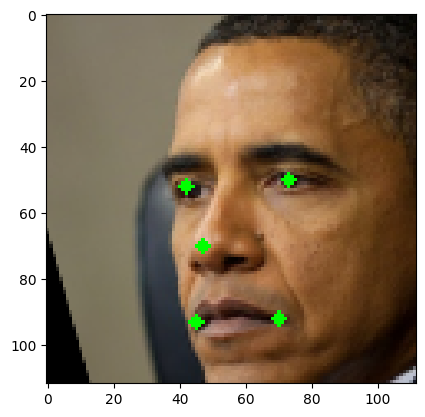

In [ ]:
aligned_img = result["aligned_face"]

import matplotlib.pyplot as plt

plt.imshow(aligned_img)

In [ ]:
imgs = [cv2.imread(x) for x in ["001_cam1_1.jpg", "001_frontal.jpg"]]
mosaic = ff.build_mosaic(imgs, mosaic_shape=(2, 1))
mosaic.shape

(118, 236, 3)

In [ ]:
results = ff.process_image_multiple_faces("tela.png", draw_keypoints=True)
results[0].keys(), results[0]["keypoints"], results[0]["bbox"], results[0]["det_score"]

/home/rafael/miniconda3/envs/ffdev/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


(dict_keys(['keypoints', 'ipd', 'embedding', 'norm', 'bbox', 'det_score', 'aligned_face', 'gender', 'age', 'pitch', 'yaw', 'roll', 'fiqa_score']),
 array([[471.42743, 418.60498],
        [522.68933, 418.05362],
        [498.82196, 449.08923],
        [479.3499 , 476.44193],
        [514.33453, 476.06885]], dtype=float32),
 array([441, 355, 548, 506]),
 0.8962144)

## Comparação entre duas imagens

In [ ]:
# | export
@patch
def compare(self: ForensicFace, img1path: str, img2path: str):
    """
    Compares the similarity between two face images based on their embeddings.

    Parameters:
        - img1path (str): Path to the first image file
        - img2path (str): Path to the second image file

    Returns:
        A float representing the similarity score between the two faces based on their embeddings.
        The score ranges from -1.0 to 1.0, where 1.0 represents a perfect match and -1.0 represents a complete mismatch.
    """
    img1data = self.process_image(img1path)
    assert len(img1data) > 0, f"No face detected in {img1path}"
    img2data = self.process_image(img2path)
    assert len(img2data) > 0, f"No face detected in {img2path}"
    return np.dot(img1data["embedding"], img2data["embedding"]) / (
        img1data["norm"] * img2data["norm"]
    )

In [ ]:
ff.compare("obama.png", "obama2.png")

0.8556277

## Agregação de embeddings

In [ ]:
# | export
@patch
def aggregate_embeddings(self: ForensicFace, embeddings, weights=None, method="mean"):
    """
    Aggregates multiple embeddings into a single embedding.

    Args:
        embeddings (numpy.ndarray): A 2D array of shape (num_embeddings, embedding_dim) containing the embeddings to be
            aggregated.
        weights (numpy.ndarray, optional): A 1D array of shape (num_embeddings,) containing the weights to be assigned
            to each embedding. If not provided, all embeddings are equally weighted.

        method (str, optional): choice of agregating based on the mean or median of the embeddings. Possible values are
            'mean' and 'median'.

    Returns:
        numpy.ndarray: A 1D array of shape (embedding_dim,) containing the aggregated embedding.
    """
    if weights is None:
        weights = np.ones(embeddings.shape[0], dtype="int")
    assert embeddings.shape[0] == weights.shape[0]
    assert method in ["mean", "median"]
    if method == "mean":
        return np.average(embeddings, axis=0, weights=weights)
    else:
        weighted_embeddings = np.array([w * e for w, e in zip(weights, embeddings)])
        return np.median(weighted_embeddings, axis=0)

In [ ]:
# | export
@patch
def aggregate_from_images(
    self: ForensicFace, list_of_image_paths, method="mean", quality_weight=False
):
    """
    Given a list of image paths, this method returns the average embedding of all faces found in the images.

    Args:
        list_of_image_paths (List[str]): List of paths to images.
        method (str, optional): choice of agregating based on the mean or median of the embeddings. Possible values are
            'mean' and 'median'.
        quality_weight (boolean, optional): If True, use the FIQA(L) score as a weight for aggregation.

    Returns:
        Union[np.ndarray, List]: If one or more faces are found, returns a 1D numpy array of shape (512,) representing the
        average embedding. Otherwise, returns an empty list.
    """
    if quality_weight:
        assert (
            self.extended == True
        ), "You must initialize ForensicFace with extended = True"
    embeddings = []
    weights = []
    for imgpath in list_of_image_paths:
        d = self.process_image(imgpath)
        if len(d) > 0:
            embeddings.append(d["embedding"])
            weights.append(d["fiqa_score"] if quality_weight == True else 1.0)
    if len(embeddings) > 0:
        return self.aggregate_embeddings(
            np.array(embeddings), method=method, weights=np.array(weights)
        )
    else:
        return []

In [ ]:
ff = ForensicFace(extended=True)

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'device_id': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0'}}
find model: /home/rafael/.insightface/models/sepaelv2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'device_id': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'cud

In [ ]:
aggregated = ff.aggregate_from_images(["obama.png", "obama2.png"], quality_weight=True)
aggregated.shape

(512,)

## Extração de faces de vídeos com margem

In [ ]:
# | export


@patch
def _get_extended_bbox(self: ForensicFace, bbox, frame_shape, margin_factor):
    """
    Computes and returns the bounding box with extended margins.

    Parameters:
        bbox (ndarray): The bounding box coordinates (startX, startY, endX, endY).
        frame_shape (tuple): The shape of the video frame (height, width, channels).
        margin_factor (float): The factor to be applied for computing the margin.

    Returns:
        A list with the coordinates of the extended bounding box (startX_out, startY_out, endX_out, endY_out).
    """
    # add a margin on the bounding box
    (startX, startY, endX, endY) = bbox.astype("int")
    (h, w) = frame_shape[:2]
    out_width = (endX - startX) * margin_factor
    out_height = (endY - startY) * margin_factor

    startX_out = int((startX + endX) / 2 - out_width / 2)
    endX_out = int((startX + endX) / 2 + out_width / 2)
    startY_out = int((startY + endY) / 2 - out_height / 2)
    endY_out = int((startY + endY) / 2 + out_height / 2)

    # tests if the output bbox coordinates are out of frame limits
    if startX_out < 0:
        startX_out = 0
    if endX_out > int(w):
        endX_out = int(w)
    if startY_out < 0:
        startY_out = 0
    if endY_out > int(h):
        endY_out = int(h)
    return [startX_out, startY_out, endX_out, endY_out]


@patch
def extract_faces(
    self: ForensicFace,
    video_path: str,  # path to video file
    dest_folder: str = None,  # folder used to save extracted faces. If not provided, a new folder with the video name is created
    every_n_frames: int = 1,  # skip some frames
    margin: float = 2.0,  # margin to add to each face, w.r.t. detected bounding box
    start_from: float = 0.0,  # seconds after video start to begin processing
):
    """
    Extracts faces from a video and saves them as individual images.

    Parameters:
        video_path (str): The path to the input video file.
        dest_folder (str, optional): The path to the output folder. If not provided, a new folder with the same name as the input video file is created.
        every_n_frames (int, optional): Extract faces from every n-th frame. Default is 1 (extract faces from all frames).
        margin (float, optional): The factor by which the detected face bounding box should be extended. Default is 2.0.
        start_from (float, optional): The time point (in seconds) after which the video frames should be processed. Default is 0.0.

    Returns:
        The number of extracted faces.
    """
    if dest_folder is None:
        dest_folder = os.path.splitext(video_path)[0]

    os.makedirs(dest_folder, exist_ok=True)

    # initialize video stream from file
    vs = cv2.VideoCapture(video_path)
    fps = vs.get(cv2.CAP_PROP_FPS)
    start_frame = int(fps * start_from)
    total_frames = int(vs.get(cv2.CAP_PROP_FRAME_COUNT)) // every_n_frames

    # seek to starting frame
    vs.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    current_frame = start_frame
    nfaces = 0
    with tqdm(
        total=total_frames,
        bar_format="Frames processed: {n}/{total} | Time elapsed: {elapsed}",
    ) as pbar:
        while True:

            ret, frame = vs.read()

            if not ret:
                break

            current_frame = current_frame + 1
            if (current_frame % every_n_frames) != 0:
                continue

            (h, w) = frame.shape[:2]

            faces = self.detectmodel.get(frame)
            for i, face in enumerate(faces):
                startX, startY, endX, endY = face.bbox.astype("int")
                faceW = endX - startX
                faceH = endY - startY
                outBbox = self._get_extended_bbox(
                    face.bbox, frame.shape, margin_factor=margin
                )
                # export the face (with added margin)
                face_crop = frame[outBbox[1] : outBbox[3], outBbox[0] : outBbox[2]]
                face_img_path = os.path.join(
                    dest_folder, f"frame_{current_frame:07}_face_{i:02}.png"
                )
                cv2.imwrite(face_img_path, face_crop)
                nfaces += 1
            pbar.update(1)
    vs.release()
    return nfaces

In [ ]:
ff = ForensicFace()

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'device_id': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0'}}
find model: /home/rafael/.insightface/models/sepaelv2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'device_id': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'cud

In [ ]:
ff.extract_faces(
    video_path="/home/rafael/video/video.mp4",
    start_from=0,
    every_n_frames=200,
    dest_folder="/home/rafael/video_faces",
)

Frames processed: 0/4973 | Time elapsed: 00:00

/home/rafael/miniconda3/envs/ffdev/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4
Frames processed: 4973/4973 | Time elapsed: 01:22


2011

## Processing aligned images

In [ ]:
# | export


@patch
def process_aligned_face_image(self: ForensicFace, rgb_aligned_face: np.ndarray):
    assert rgb_aligned_face.shape == (112, 112, 3)
    bgr_aligned_face = rgb_aligned_face[..., ::-1].copy()
    ada_inputs = {
        self.ort_ada.get_inputs()[0].name: self._to_input_ada(bgr_aligned_face)
    }
    normalized_embedding, norm = self.ort_ada.run(None, ada_inputs)
    ret = {"embedding": normalized_embedding.flatten() * norm.flatten()[0]}
    if self.extended:
        _, fiqa_score = self.ort_fiqa.run(None, ada_inputs)
        ret = {**ret, **{"fiqa_score": fiqa_score[0][0]}}
    return ret

In [ ]:
ff = ForensicFace(extended=True)

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'device_id': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'cudnn_conv_use_max_workspace': '1', 'tunable_op_enable': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0'}}
find model: /home/rafael/.insightface/models/sepaelv2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'device_id': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'gpu_external_empty_cache': '0', 'cud

In [ ]:
ret = ff.process_image_single_face("obama.png")
ret2 = ff.process_aligned_face_image(ret["aligned_face"])

In [ ]:
np.allclose(ret["embedding"], ret2["embedding"])

True

In [ ]:
ret["fiqa_score"], ret2["fiqa_score"]

(2.1983922, 2.1983922)

#